In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =6.375563e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 720

data w_diffuse
     &     /1.8 , 1.8 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.8,
     &     1.8/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.9,
     &     0.95/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

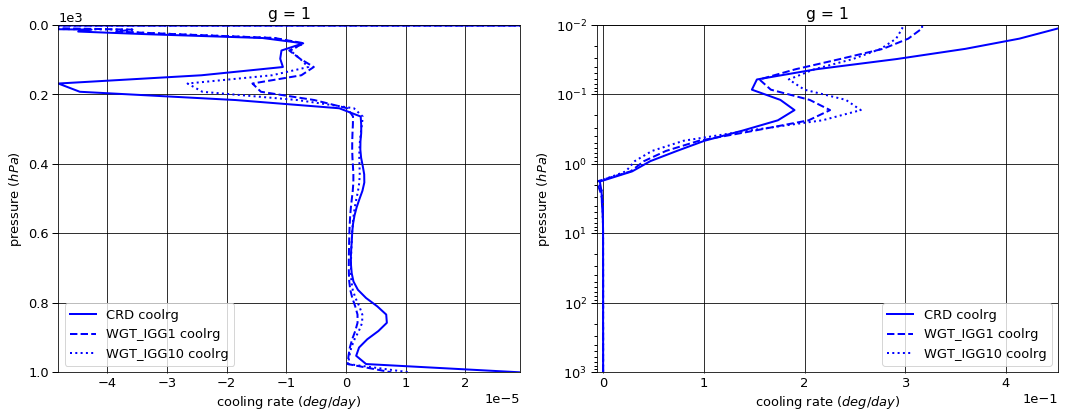

# Figure: cooling rate g-group 2

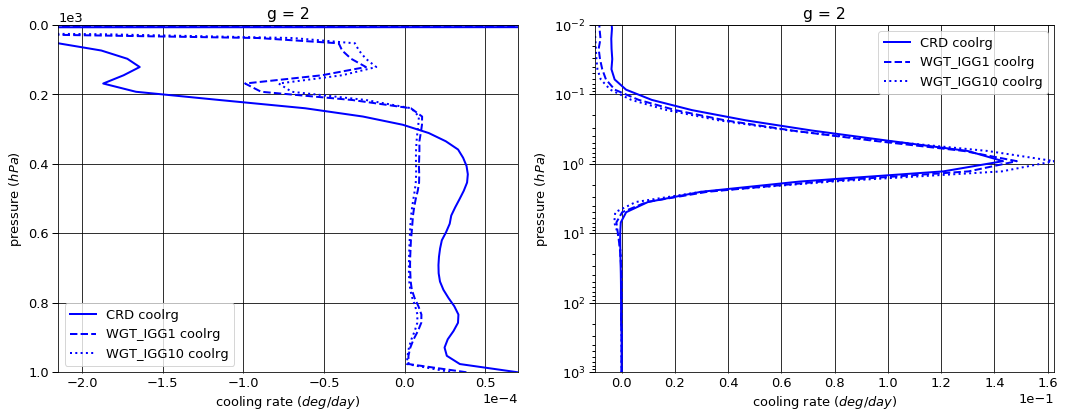

# Figure: cooling rate g-group 3

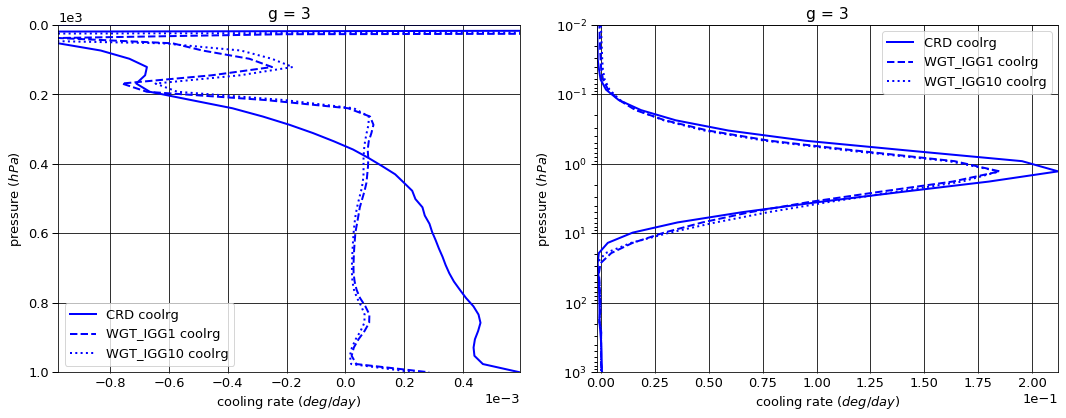

# Figure: cooling rate g-group 4

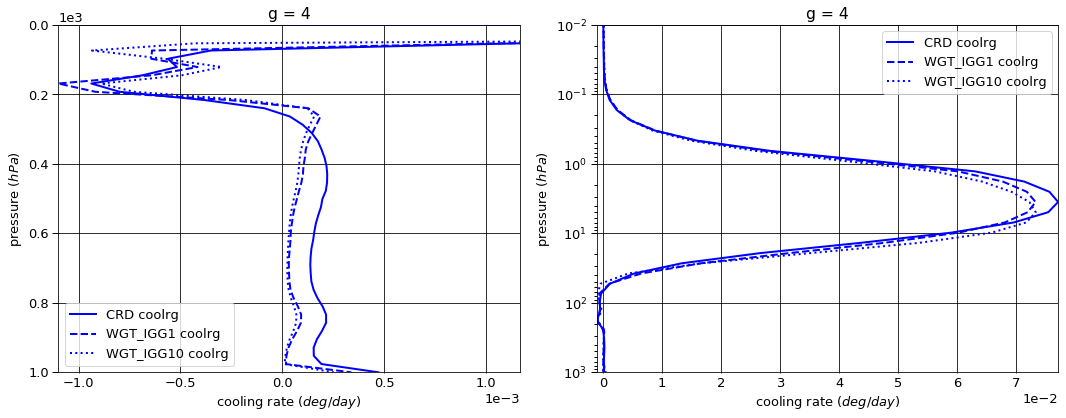

# Figure: cooling rate g-group 5

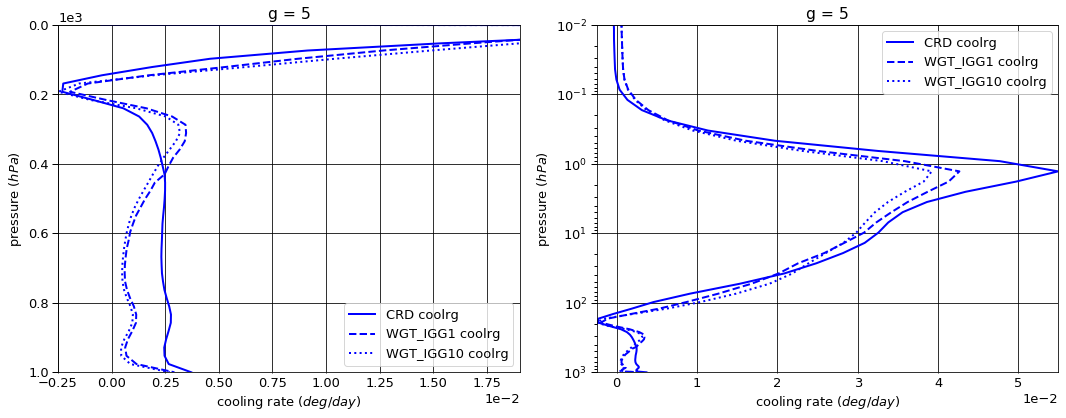

# Figure: cooling rate g-group 6

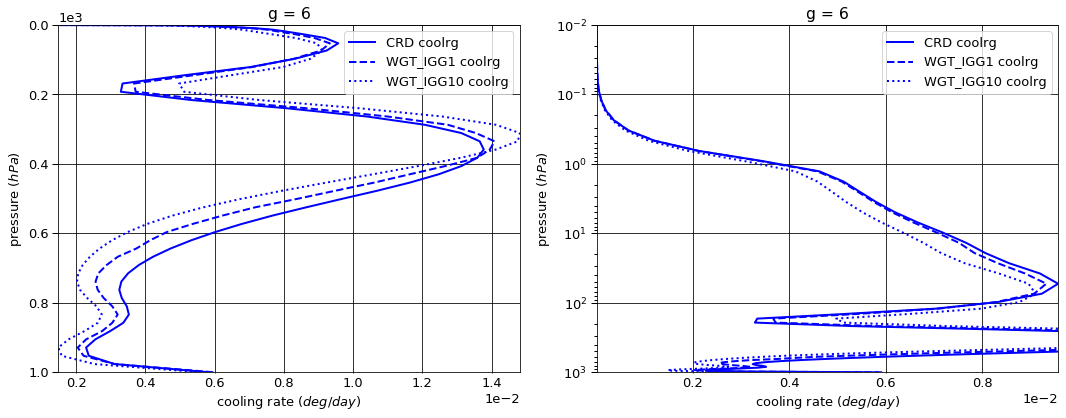

# Figure: cooling rate g-group 7

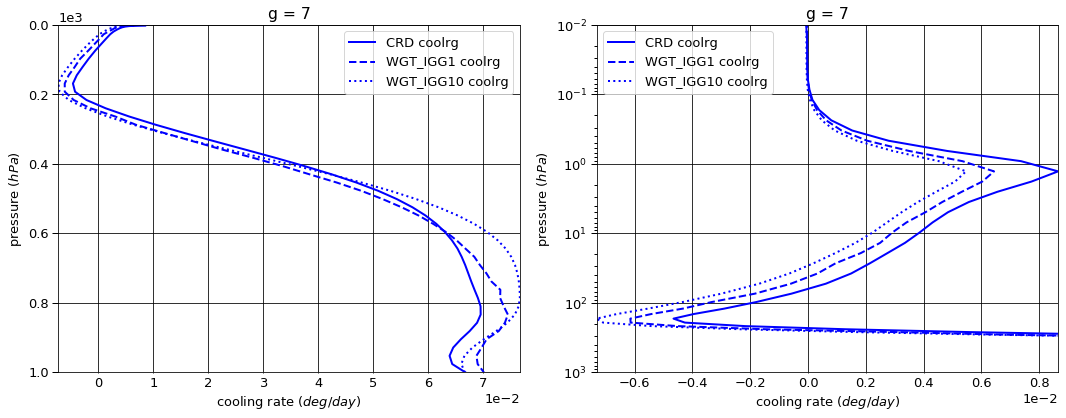

# Figure: cooling rate g-group 8

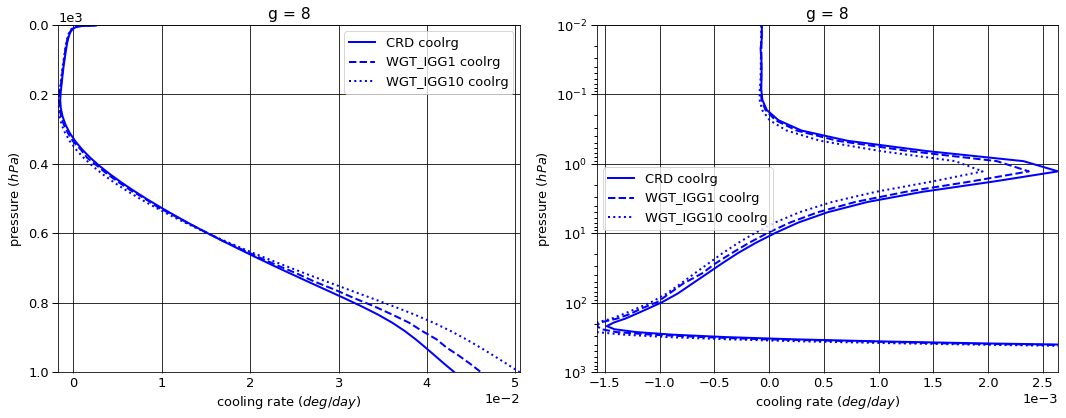

# Figure: cooling rate g-group 9

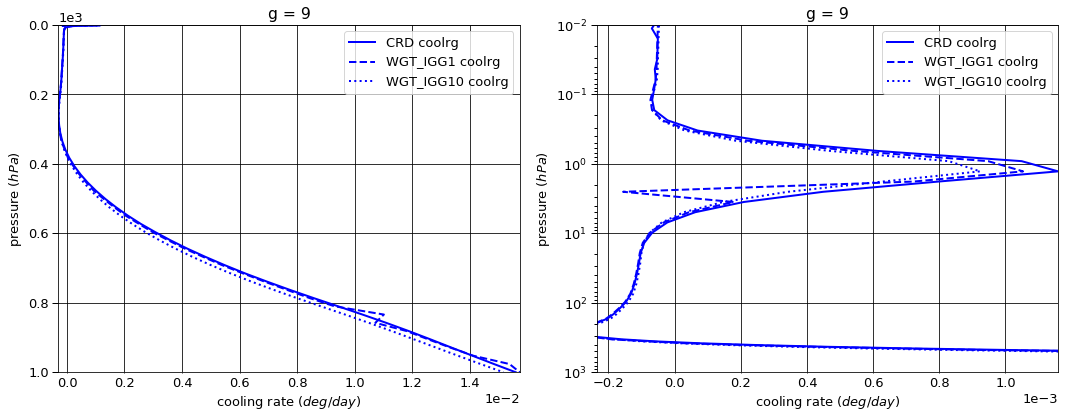

# Figure: cooling rate g-group total

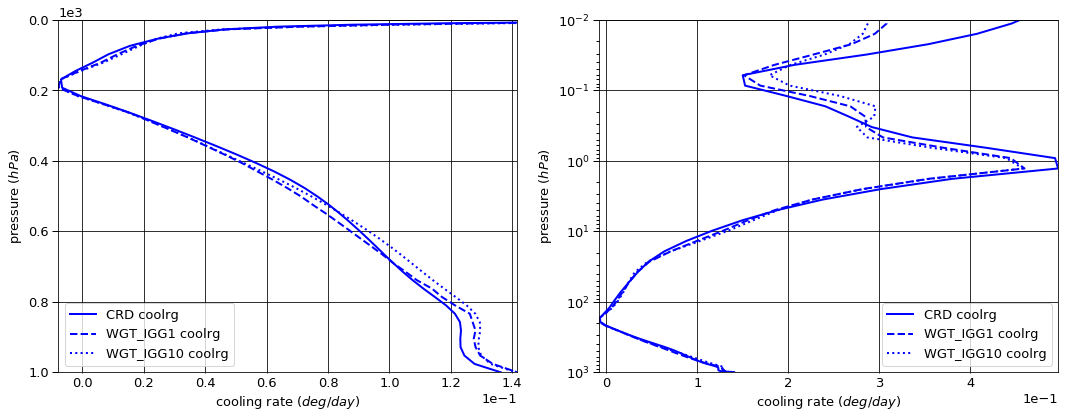

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014466  0.000000  -0.014466
  1013.0   76     -0.037941  0.037849  -0.000092
2 0.0      1      -0.025032  0.000000  -0.025032
  1013.0   76     -0.039637  0.039173  -0.000465
3 0.0      1      -0.113902  0.000000  -0.113902
  1013.0   76     -0.206199  0.191335  -0.014864
4 0.0      1      -0.163208  0.000000  -0.163208
  1013.0   76     -0.399625  0.395986  -0.003639
5 0.0      1      -0.518990  0.000000  -0.518990
  1013.0   76     -1.284243  1.188540  -0.095703
6 0.0      1      -0.864359  0.000000  -0.864359
  1013.0   76     -2.275827  2.244898  -0.030928
7 0.0      1      -6.318527  0.000000  -6.318527
  1013.0   76     -9.673479  8.169070  -1.504409
8 0.0      1      -6.315205  0.000000  -6.315205
  1013.0   76     -6.944650  2.322749  -4.621902
9 0.0      1     -11.645191  0.000000 -11.645191
  1013.0   76    -11.775941  0.613046 -11.162895


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014122  0.000000  -0.014122
  1013.0   76     -0.037941  0.037920  -0.000021
2 0.0      1      -0.025719  0.000000  -0.025719
  1013.0   76     -0.039637  0.039528  -0.000109
3 0.0      1      -0.103393  0.000000  -0.103393
  1013.0   76     -0.206199  0.205335  -0.000865
4 0.0      1      -0.160155  0.000000  -0.160155
  1013.0   76     -0.399625  0.398674  -0.000952
5 0.0      1      -0.398351  0.000000  -0.398351
  1013.0   76     -1.284243  1.271776  -0.012467
6 0.0      1      -0.819154  0.000000  -0.819154
  1013.0   76     -2.275827  2.246216  -0.029611
7 0.0      1      -6.349131  0.000000  -6.349131
  1013.0   76     -9.673479  8.153514  -1.519966
8 0.0      1      -6.304348  0.000000  -6.304348
  1013.0   76     -6.944650  2.393129  -4.551521
9 0.0      1     -11.645894  0.000000 -11.645894
  1013.0   76    -11.775941  0.610301 -11.165640


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.013611  0.000000  -0.013611
  1013.0   76     -0.037941  0.037912  -0.000029
2 0.0      1      -0.026148  0.000000  -0.026148
  1013.0   76     -0.039637  0.039555  -0.000082
3 0.0      1      -0.105360  0.000000  -0.105360
  1013.0   76     -0.206199  0.205519  -0.000680
4 0.0      1      -0.161763  0.000000  -0.161763
  1013.0   76     -0.399625  0.398922  -0.000704
5 0.0      1      -0.388624  0.000000  -0.388624
  1013.0   76     -1.284243  1.274053  -0.010190
6 0.0      1      -0.783529  0.000000  -0.783529
  1013.0   76     -2.275827  2.251705  -0.024122
7 0.0      1      -6.178248  0.000000  -6.178248
  1013.0   76     -9.673479  8.549975  -1.123504
8 0.0      1      -6.306647  0.000000  -6.306647
  1013.0   76     -6.944650  2.479336  -4.465314
9 0.0      1     -11.655765  0.000000 -11.655765
  1013.0   76    -11.775941  0.572213 -11.203728


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000343  0.000000  0.000343
  1013.0   76     0.000000  0.000071  0.000071
2 0.0      1     -0.000687  0.000000 -0.000687
  1013.0   76     0.000000  0.000356  0.000356
3 0.0      1      0.010509  0.000000  0.010509
  1013.0   76     0.000000  0.014000  0.014000
4 0.0      1      0.003053  0.000000  0.003053
  1013.0   76     0.000000  0.002687  0.002687
5 0.0      1      0.120639  0.000000  0.120639
  1013.0   76     0.000000  0.083236  0.083236
6 0.0      1      0.045206  0.000000  0.045206
  1013.0   76     0.000000  0.001318  0.001318
7 0.0      1     -0.030604  0.000000 -0.030604
  1013.0   76     0.000000 -0.015557 -0.015557
8 0.0      1      0.010857  0.000000  0.010857
  1013.0   76     0.000000  0.070381  0.070381
9 0.0      1     -0.000703  0.000000 -0.000703
  1013.0   76     0.000000 -0.002744 -0.002745


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000855  0.000000  0.000855
  1013.0   76     0.000000  0.000063  0.000063
2 0.0      1     -0.001116  0.000000 -0.001116
  1013.0   76     0.000000  0.000383  0.000383
3 0.0      1      0.008541  0.000000  0.008541
  1013.0   76     0.000000  0.014184  0.014184
4 0.0      1      0.001445  0.000000  0.001445
  1013.0   76     0.000000  0.002935  0.002935
5 0.0      1      0.130366  0.000000  0.130366
  1013.0   76     0.000000  0.085513  0.085513
6 0.0      1      0.080831  0.000000  0.080831
  1013.0   76     0.000000  0.006807  0.006806
7 0.0      1      0.140279  0.000000  0.140279
  1013.0   76     0.000000  0.380905  0.380905
8 0.0      1      0.008559  0.000000  0.008559
  1013.0   76     0.000000  0.156588  0.156588
9 0.0      1     -0.010574  0.000000 -0.010574
  1013.0   76     0.000000 -0.040832 -0.040833

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.468105
  1001.112500 75     0.000029
2 0.000312    1     -0.006274
  1001.112500 75     0.000070
3 0.000312    1     -0.002663
  1001.112500 75     0.000593
4 0.000312    1     -0.000008
  1001.112500 75     0.000472
5 0.000312    1     -0.000471
  1001.112500 75     0.003717
6 0.000312    1      0.000005
  1001.112500 75     0.005846
7 0.000312    1     -0.000052
  1001.112500 75     0.066816
8 0.000312    1     -0.000058
  1001.112500 75     0.043119
9 0.000312    1     -0.000042
  1001.112500 75     0.015603


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.278132
  1001.112500 75     0.000008
2 0.000312    1     -0.010285
  1001.112500 75     0.000038
3 0.000312    1     -0.001816
  1001.112500 75     0.000285
4 0.000312    1      0.000020
  1001.112500 75     0.000339
5 0.000312    1      0.000376
  1001.112500 75     0.002931
6 0.000312    1      0.000007
  1001.112500 75     0.005990
7 0.000312    1     -0.000049
  1001.112500 75     0.070200
8 0.000312    1     -0.000060
  1001.112500 75     0.046133
9 0.000312    1     -0.000043
  1001.112500 75     0.015743


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.221796
  1001.112500 75     0.000011
2 0.000312    1     -0.011746
  1001.112500 75     0.000029
3 0.000312    1     -0.001056
  1001.112500 75     0.000235
4 0.000312    1      0.000038
  1001.112500 75     0.000253
5 0.000312    1      0.000398
  1001.112500 75     0.002713
6 0.000312    1      0.000006
  1001.112500 75     0.005608
7 0.000312    1     -0.000065
  1001.112500 75     0.066724
8 0.000312    1     -0.000062
  1001.112500 75     0.050510
9 0.000312    1     -0.000040
  1001.112500 75     0.015177


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.899725e-01
  1001.112500 75    -2.152678e-05
2 0.000312    1     -4.011475e-03
  1001.112500 75    -3.168782e-05
3 0.000312    1      8.471563e-04
  1001.112500 75    -3.081184e-04
4 0.000312    1      2.806409e-05
  1001.112500 75    -1.329847e-04
5 0.000312    1      8.469421e-04
  1001.112500 75    -7.857744e-04
6 0.000312    1      2.004575e-06
  1001.112500 75     1.437336e-04
7 0.000312    1      3.162599e-06
  1001.112500 75     3.383364e-03
8 0.000312    1     -1.509773e-06
  1001.112500 75     3.014025e-03
9 0.000312    1     -6.516820e-07
  1001.112500 75     1.400850e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.246309
  1001.112500 75    -0.000019
2 0.000312    1     -0.005472
  1001.112500 75    -0.000041
3 0.000312    1      0.001607
  1001.112500 75    -0.000358
4 0.000312    1      0.000046
  1001.112500 75    -0.000219
5 0.000312    1      0.000868
  1001.112500 75    -0.001003
6 0.000312    1      0.000001
  1001.112500 75    -0.000238
7 0.000312    1     -0.000013
  1001.112500 75    -0.000092
8 0.000312    1     -0.000004
  1001.112500 75     0.007392
9 0.000312    1      0.000002
  1001.112500 75    -0.000426

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.978879,0.000000,-25.978879
1013.0,76,-32.637543,15.202646,-17.434897



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.820267,0.000000,-25.820267
1013.0,76,-32.637543,15.356393,-17.281151



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.619694,0.00000,-25.619694
1013.0,76,-32.637543,15.80919,-16.828353



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.158612,0.000000,0.158612
1013.0,76,0.000000,0.153747,0.153746



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.359185,0.000000,0.359185
1013.0,76,0.000000,0.606544,0.606544


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.458541
1001.112500,75,0.136264



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.266282
1001.112500,75,0.141665



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.209269
1001.112500,75,0.141261



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.192259
1001.112500,75,0.005401



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.249272
1001.112500,75,0.004996


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001193
2,0.001187,0.001235
3,0.006188,0.006422
4,0.011875,0.012540
5,0.038500,0.040013
6,0.067937,0.071126
7,0.290187,0.301164
8,0.213688,0.211927
9,0.369312,0.354380


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.076063e-19
2,1.947095e-20
3,1.826139e-21
4,1.678020e-21
5,1.581825e-22
6,5.839038e-22
7,6.102842e-23
8,6.378566e-24
9,2.959058e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.076063e-19,NaN,0.001125,0.001193,0.001125,0.001193,1.0
2,1.947095e-20,0.093788,0.001187,0.001235,0.002312,0.002428,1.0
3,1.826139e-21,0.093788,0.006188,0.006422,0.008500,0.008850,1.0
4,1.678020e-21,0.918890,0.011875,0.012540,0.020375,0.021390,10.0
5,1.581825e-22,0.094267,0.038500,0.040013,0.058875,0.061403,10.0
6,5.839038e-22,3.691330,0.067937,0.071126,0.126812,0.132529,500.0
7,6.102842e-23,0.104518,0.290187,0.301164,0.417000,0.433693,500.0
8,6.378566e-24,0.104518,0.213688,0.211927,0.630687,0.645620,500.0
9,2.959058e-25,0.046391,0.369312,0.354380,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.535756e-19  3.105266e-19   1.782699  2.158396e-03
      2 0.000312     1.557905e-20  8.963400e-21   1.738074  6.145550e-05
      3 0.000312     9.908171e-22  6.624178e-22   1.495758  4.201844e-06
      4 0.000312     1.194255e-23  1.131529e-23   1.055435  6.122542e-08
      5 0.000312     2.067295e-23  1.146875e-23   1.802545  8.019849e-08
      6 0.000312     1.709371e-25  1.693078e-25   1.009624  8.996772e-10
      7 0.000312     3.285961e-25  2.663965e-25   1.233485  1.541865e-09
      8 0.000312     1.573280e-25  6.737860e-26   2.334984  7.851978e-10
      9 0.000312     4.867747e-26  6.347370e-27   7.668920  2.464695e-10
2     1 0.000750     5.559891e-19  3.116656e-19   1.783928  8.728885e-04
      2 0.000750     1.569554e-20  9.031540e-21   1.737859  2.493997e-05
      3 0.000750     1.000125e-21  6.674017e-22   1.498536  1.706761e-06
      4 0.000750     1.220466e-23  1.156597e-23   1.055221  2.520502e-08
      5 0.000750     2.089261e-23  1.155906e-23   1.807465  3.260575e-08
      6 0.000750     1.740707e-25  1.724068e-25   1.009651  3.690149e-10
      7 0.000750     3.324951e-25  2.691277e-25   1.235455  6.278620e-10
      8 0.000750     1.595045e-25  6.794465e-26   2.347565  3.205645e-10
      9 0.000750     4.938897e-26  6.390642e-27   7.728327  1.007204e-10
3     1 0.001052     5.611659e-19  3.140854e-19   1.786667  1.234659e-03
      2 0.001052     1.594171e-20  9.172776e-21   1.737937  3.552327e-05
      3 0.001052     1.019516e-21  6.771830e-22   1.505525  2.434277e-06
      4 0.001052     1.258743e-23  1.192348e-23   1.055684  3.644633e-08
      5 0.001052     2.135231e-23  1.173718e-23   1.819203  4.659521e-08
      6 0.001052     1.792640e-25  1.775241e-25   1.009801  5.328935e-10
      7 0.001052     3.406799e-25  2.747574e-25   1.239930  9.003939e-10
      8 0.001052     1.641801e-25  6.911446e-26   2.375482  4.624873e-10
      9 0.001052     5.092989e-26  6.480880e-27   7.858484  1.456395e-10
4     1 0.001476     5.666714e-19  3.166655e-19   1.789495  1.747825e-03
      2 0.001476     1.620676e-20  9.324989e-21   1.737992  5.066314e-05
      3 0.001476     1.040516e-21  6.877693e-22   1.512884  3.476908e-06
      4 0.001476     1.303244e-23  1.234066e-23   1.056056  5.292696e-08
      5 0.001476     2.185212e-23  1.192984e-23   1.831720  6.669158e-08
      6 0.001476     1.851611e-25  1.833371e-25   1.009949  7.721171e-10
      7 0.001476     3.495905e-25  2.808566e-25   1.244730  1.293458e-09
      8 0.001476     1.692785e-25  7.037034e-26   2.405537  6.685943e-10
      9 0.001476     5.261167e-26  6.578012e-27   7.998110  2.110387e-10
5     1 0.002070     5.722039e-19  3.192683e-19   1.792235  2.473685e-03
      2 0.002070     1.647707e-20  9.480641e-21   1.737971  7.224509e-05
      3 0.002070     1.062093e-21  6.987053e-22   1.520088  4.966053e-06
      4 0.002070     1.353872e-23  1.281797e-23   1.056229  7.711110e-08
      5 0.002070     2.236771e-23  1.212850e-23   1.844227  9.545544e-08
      6 0.002070     1.916487e-25  1.897368e-25   1.010077  1.120821e-09
      7 0.002070     3.587936e-25  2.871326e-25   1.249575  1.858000e-09
      8 0.002070     1.745431e-25  7.165009e-26   2.436048  9.663916e-10
      9 0.002070     5.434879e-26  6.677192e-27   8.139468  3.057387e-10
6     1 0.002904     5.777545e-19  3.218925e-19   1.794868  3.501250e-03
      2 0.002904     1.675290e-20  9.640180e-21   1.737821  1.030415e-04
      3 0.002904     1.084310e-21  7.100974e-22   1.526989  7.095825e-06
      4 0.002904     1.412829e-23  1.337743e-23   1.056129  1.128833e-07
      5 0.002904     2.290060e-23  1.233483e-23   1.856580  1.366798e-07
      6 0.002904     1.989186e-25  1.969146e-25   1.010177  1.631761e-09
      7 0.002904     3.683159e-25  2.936111e-25   1.254434  2.669803e-09
      8 0.002904     1.799789e-25  7.295813e-26   2.466879  1.397049e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
